In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime
import seaborn as sns

In [17]:
trips = pd.read_csv("tripsAugmented.csv", converters={'full_route': lambda x: x[1:-1].replace("(", "").split('),')})

trips["start_time"] = pd.to_datetime(trips["start_time"])
trips["duration"] = pd.to_timedelta(trips["duration"])
deltaF = datetime.timedelta(minutes=1) # filter out trips which take less than 1 min
deltaC = datetime.timedelta(hours=24) # filter out trips which take longer than a day
trips = trips.loc[trips['duration'] > deltaF]
trips = trips.loc[trips['duration'] < deltaC]

timeRange = trips["start_time"].to_list()

display(trips)

Unnamed: 0                                                 id  \
0                0  route_10_2020@a2a17c30-d848-4ded-94f0-bd8ae05a...   
1                1  route_10_2020@5b2f37e6-e06a-43ae-949e-b2ffd2de...   
2                2  route_10_2020@c74f25cd-e0c6-4fe7-9a2f-7e31324f...   
3                3  route_10_2020@ff5d4317-b149-42a4-bc5e-9bc101da...   
4                4  route_10_2020@2b54f8e3-ed53-48ab-b065-43d59144...   
...            ...                                                ...   
166283      166283  route_06_2022@9f9c149d-b8af-4d43-8882-5b6d7cb9...   
166284      166284  route_06_2022@aa343271-8410-440e-9329-f8fa76ad...   
166285      166285  route_06_2022@42643acc-7592-4aa7-aff1-b667a2e3...   
166286      166286  route_06_2022@39cbaf9d-d9eb-460c-8f4d-f16ea151...   
166287      166287  route_06_2022@9ffc9c79-027a-452e-b439-fa16ea92...   

                      start_station   start_city  \
0         Main Street-Bridge Street  Northampton   
1       Village Hill-State Hospital  Northampton   
2                   Florence Center  Northampton   
3                  YMCA-Childs Park  Northampton   
4                    Jackson Street  Northampton   
...                             ...          ...   
166283            Amherst Town Hall      Amherst   
166284             University Drive      Amherst   
166285              Mackenzie Field      Holyoke   
166286                   El Corazon      Holyoke   
166287            Amherst Town Hall      Amherst   

                             end_station     end_city  \
0                        Florence Center  Northampton   
1            Village Hill-State Hospital  Northampton   
2                        Florence Center  Northampton   
3       John M Greene Hall-Smith College  Northampton   
4       State St-Mass Central Rail Trail  Northampton   
...                                  ...          ...   
166283                  University Drive      Amherst   
166284                  University Drive      Amherst   
166285    Holyoke Medical Center Station      Holyoke   
166286                     South Holyoke      Holyoke   
166287                  East Hadley Road      Amherst   

                      start_time        duration  \
0      2020-10-06 12:37:36+00:00 0 days 00:17:25   
1      2020-10-06 12:42:02+00:00 0 days 00:41:35   
2      2020-10-06 12:44:47+00:00 0 days 00:49:40   
3      2020-10-06 12:49:30+00:00 0 days 00:06:00   
4      2020-10-06 12:58:39+00:00 0 days 00:24:25   
...                          ...             ...   
166283 2022-06-07 02:20:55+00:00 0 days 00:07:00   
166284 2022-06-07 02:29:10+00:00 0 days 00:10:00   
166285 2022-06-07 02:34:58+00:00 0 days 00:07:45   
166286 2022-06-07 02:47:24+00:00 0 days 00:28:00   
166287 2022-06-07 03:38:36+00:00 0 days 00:08:45   

                                               full_route  
0       [(42.3205, -72.62829,  (42.3205, -72.62829,  (...  
1       [(42.312061666666665, -72.64750833333333,  (42...  
2       [(42.334898333333335, -72.66787166666667,  (42...  
3       [(42.328588333333336, -72.64399166666666,  (42...  
4       [(42.337208333333336, -72.64266,  (42.33720833...  
...                                                   ...  
166283  [(42.37551, -72.51947333333334,  (42.37551, -7...  
166284  [(42.36831166666666, -72.53333,  (42.368311666...  
166285  [(42.20183333333333, -72.619915,  (42.20183333...  
166286  [(42.20078, -72.60606333333334,  (42.20078, -7...  
166287  [(42.37556666666666, -72.51958,  (42.375566666...  

[142181 rows x 9 columns]

In [18]:
routesDict = {}
for index, row in trips.iterrows():
    ID = row['id']
    time = row['start_time']
    locations = row['full_route']
    duration = row['duration']
    routesDict[ID] = {"locations": locations, "start_time": time, "duration": duration}


In [31]:
import random
routeID = random.choice(list(routesDict.keys()))
print(routeID)

route_06_2021@a09a430d-bd7e-4775-b3e5-650b7efebdfb


-72.52938 42.37556166666667 -72.51698833333333 42.40358833333333
route_06_2021@a09a430d-bd7e-4775-b3e5-650b7efebdfb: start time: 2021-06-15 23:04:10+00:00, duration: 0 days 00:19:50


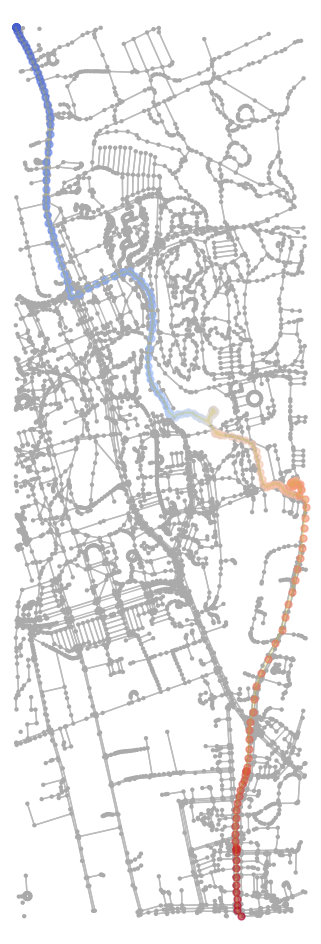

In [32]:
import pandas as pd
import numpy as np
import math
import osmnx as ox
import networkx as nx
import pickle
from time import time
import time
from xml.dom import NotFoundErr
import itertools
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import osmnx.geometries as gx
import numpy as np
import math

route = routesDict[routeID]
locationList = [x[1:].replace("(", "").replace(")", "").split(',') for x in route["locations"]]
for tuple in locationList:
    tuple[0] = float(tuple[0])
    tuple[1] = float(tuple[1])
startTime = route["start_time"]
duration = route["duration"]

pointsList = []
for (lat, long) in locationList:
    pointsList.append(Point(long, lat))

# convert to GeoDataFrame (enables next step)
points = gpd.GeoSeries(pointsList, crs='epsg:4326')
gpd = gpd.GeoDataFrame({'geometry': pointsList})

minx, miny, maxx, maxy = gpd.geometry.total_bounds
print(minx, miny, maxx, maxy)
print("{}: start time: {}, duration: {}".format(routeID, startTime, duration))
if (minx == maxx) and (miny == maxy):
    print("invalid route!")
else:
    G = ox.graph_from_bbox(miny, maxy, minx, maxx, simplify=False, retain_all=True)

    # project to CRS (coordinate reference system) used by the projected graph (this is for accuracy)
    pointsProg = points.to_crs(G.graph['crs'])

fig, ax = ox.plot_graph(
    G, bgcolor="w", node_color="#AAAAAA", figsize=(20, 12), node_size=10, edge_linewidth=1, edge_color="#BBBBBB", show=False, save=False, close=False
)

cmap = plt.cm.get_cmap('coolwarm',len(pointsProg))
colors = list(cmap(np.arange(len(pointsProg))))
colors[0] = "#000000"
pointsX = []
pointsY = []
for i, point in enumerate(pointsProg):
    pointsX.append(point.x)
    pointsY.append(point.y)
    ax.scatter(point.x, point.y, color=colors[i], s = 25, alpha = 0.6)
ax.plot(pointsX, pointsY, c="y", alpha = 0.2)

extent = ax.bbox.transformed(fig.dpi_scale_trans.inverted())
plt.draw()
plt.show()